In [1]:
import numpy  as np
import healpy as hp
import matplotlib.pyplot as plt
import sys
#
sys.path.append('../sht')
from  mask_deconvolution import MaskDeconvolution
#
%load_ext autoreload
%autoreload 2

# Test the pseudo-spectrum code.

We want to test that the mask convolution and the mode-coupling matrix are being computed correctly.

First we make an apodized mask for our survey.  In our case this will be a Gaussian, centered at $x=1$, $y=z=0$ and set to zero beyond some radius -- but this is essentially arbitrary.

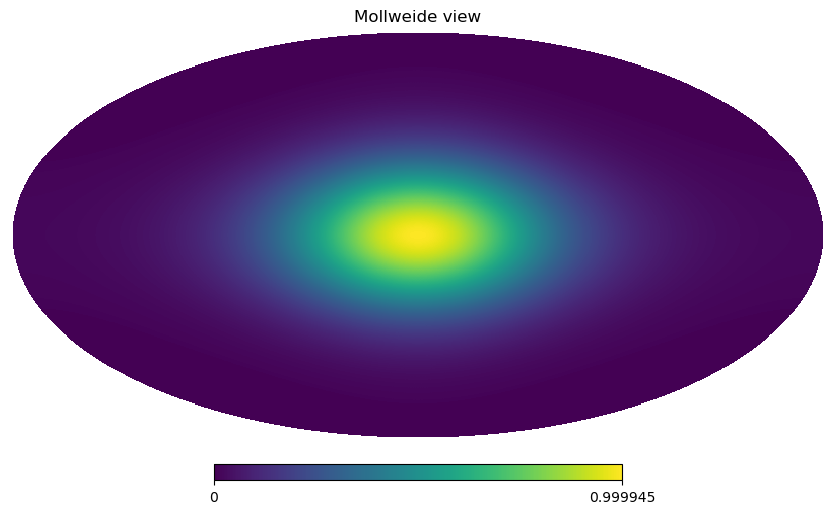

In [2]:
# Generate an apodized mask that is centered on x=1, y=z=0 and
# has an nside of 512.
nside = 512
npix  = 12*nside**2
th,ph = hp.pixelfunc.pix2ang(nside,np.arange(npix),lonlat=False)
#
x,y,z = np.sin(th)*np.cos(ph),np.sin(th)*np.sin(ph),np.cos(th)
rad2  = (x-1)**2/0.5 + y**2/0.5 + z**2/0.1
mask  = np.exp(-0.5*rad2)
mask[mask<0.01] = 0.0
# and look at it.
hp.mollview(mask)

Text(0, 0.5, '$W_\\ell$')

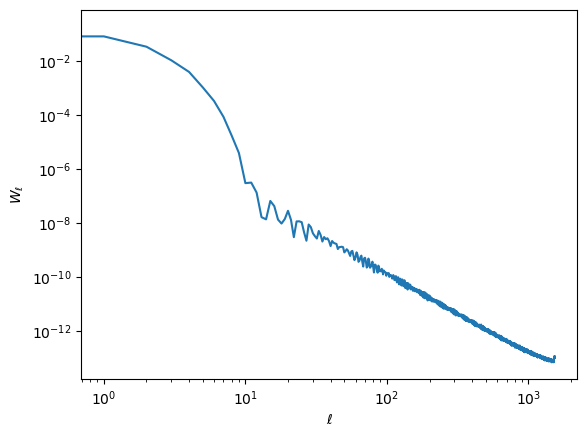

In [3]:
# Let's look at the window function, just to see how
# it looks.
wl = hp.anafast(mask)
#
plt.loglog(wl)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')

Now we make some mock data using Healpy's synfast routine to generate a Gaussian random field with an input (angular) power spectrum.  We can then mask this map.

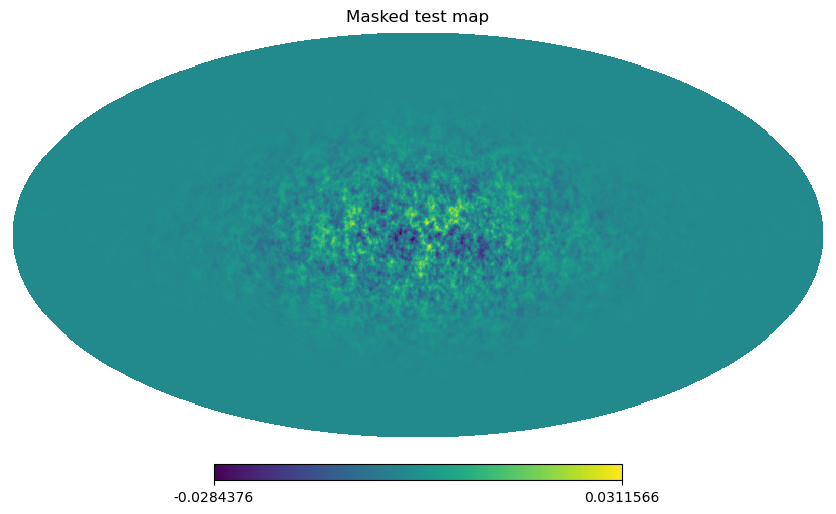

In [4]:
# Make a fiducial angular power spectrum to generate data
# from.  We want this to be very "red" so that we can run
# at reasonably low resolution without worrying about aliasing.
lmax = 3000
ell0 = 30
ell1 = 200
ells = np.arange(lmax)
clth = 1e-6*ell0/(ells+ell0)*(ell1/(ells+ell1))**6
# Let's draw a realization of this field
tmap = hp.synfast(clth,nside=nside)
hp.mollview(mask*tmap, title="Masked test map")

Now we analyze this masked data using Healpy's anafast routine.  Note we're going to concentrate on the lower ells here, even though we have a high enough Nside to go to higher ell.

In [5]:
Nl   = 2**8
lmax = Nl-1
print("Nl=",Nl," or lmax=",lmax)

Nl= 256  or lmax= 255


In [6]:
# Generate the signal and window function.
cl = hp.anafast(mask*tmap,lmax=lmax)
wl = hp.anafast(mask)

We initialize an instance of the MaskDeconvolution class. This computes the coupling matrix.  This isn't optimized, but we won't have to run it again as long as we're dealing with the same mask so we don't mind.

Later it will be useful to have a matrix to higher ell, so generate that too.

In [7]:
%time MD = MaskDeconvolution(Nl,wl)
%time MD2= MaskDeconvolution(Nl+64,wl)

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 16.1 s, sys: 206 ms, total: 16.3 s
Wall time: 16.2 s
Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 29.9 s, sys: 177 ms, total: 30.1 s
Wall time: 30.1 s


This class handles the mode coupling and decoupling, the window matrices and so on.  Let's look at the window function matrix, which converts from a "theory" $C_\ell$ to a mode-decoupled pseudo-spectrum:
$$
  \tilde{C}_b = \sum_{\ell} W_{b\ell} C_\ell^{\rm thy}
$$

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Text(0, 0.5, '$W_{b\\ell}$')

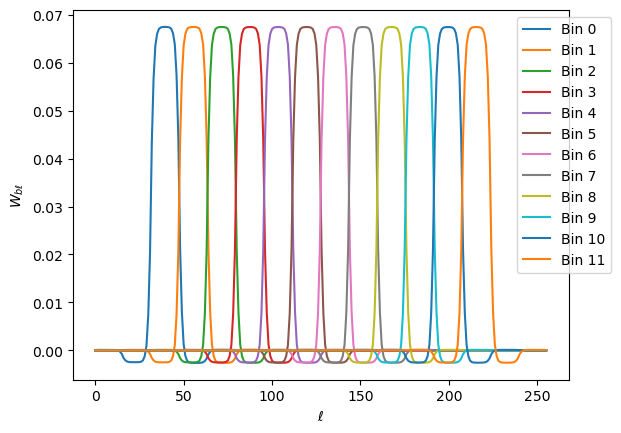

In [8]:
# Use the helper function to generate linearly spaced bins
# in ell of width NperBin.  The first two bins are removed because
# they have support to very low ell and the last bins because
# they have support past lmax (see discussion below).
# Note that you want to compute the window matrix and then
# throw away the edge bins, not throw away the edge bins first
# because the "edge" bins affect the mode decoupling step.
NperBin = 2**4
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)[2:-2,:]
# Look at the sums over ell.
print(Mbl.sum(axis=1))
# and plot the matrix:
for i in range(Mbl.shape[0]):
    plt.plot(Mbl[i,:],label='Bin '+str(i))
plt.legend(bbox_to_anchor=(1.1,1.0))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_{b\ell}$')

We can then very quickly deconvolve the mode-coupling matrix from some observed bandpowers.

In [9]:
# Work out the binned and decoupled pseudo-spectrum.
binned_ells, Cb_decoupled = MD(cl,bins)
binned_ells, Cb_decoupled = binned_ells[2:-2],Cb_decoupled[2:-2]
# Convolve the theory with the bandpower window functions
_, convolved_theory_cl = MD.convolve_theory_Cls(clth,bins)
convolved_theory_cl    = convolved_theory_cl[2:-2]

(0.0, 240.5)

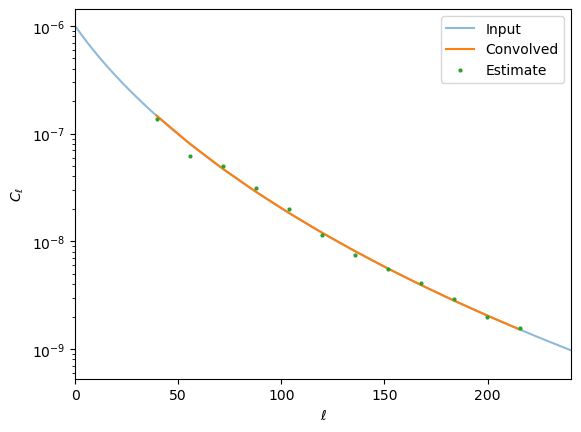

In [10]:
plt.plot(np.arange(Nl),clth[:Nl],alpha=0.5,label='Input')
plt.plot(binned_ells, convolved_theory_cl, label='Convolved')
plt.plot(binned_ells, Cb_decoupled, label='Estimate', ls='', marker='o', markersize=2)
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.legend()
plt.xlim([0,binned_ells[-1]+25])

Let's average over many realizations

In [11]:
Nmc = 500
#
Cb_array = np.zeros( (Nmc,Cb_decoupled.size) )
Cl_array = np.zeros( (Nmc,Nl) )
#
for i in range(Nmc):
    tmap = hp.synfast(clth,nside=nside)
    cl   = hp.anafast(mask*tmap,lmax=lmax)
    binned_ells, pseudo_Cb = MD(cl,bins)
    binned_ells   = binned_ells[2:-2]
    Cl_array[i,:] = cl
    Cb_array[i,:] = pseudo_Cb[2:-2]
avg_Cl           = np.mean(Cl_array,axis=0)
err_Cl           = np.std( Cl_array,axis=0)/np.sqrt(Nmc-1.0)    
avg_Cb_decoupled = np.mean(Cb_array,axis=0)
err_Cb_decoupled = np.std( Cb_array,axis=0)/np.sqrt(Nmc-1.0)

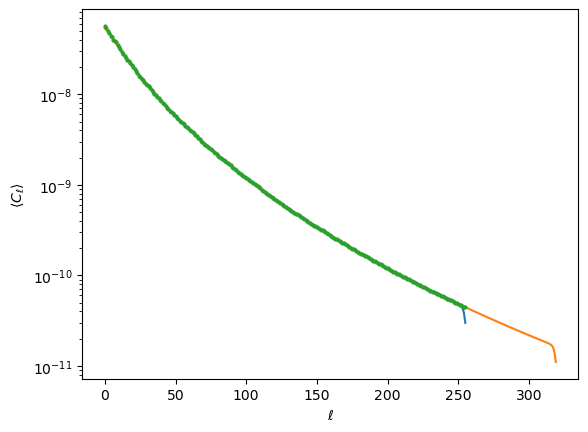

In [12]:
# Theory prediction for the un-corrected anafast mean.
thy = np.dot(MD.Mll,clth[:Nl])
plt.plot(np.arange(Nl),thy,'-',color='C0')
# extended to higher ell using a larger mask-deconvolution instance
thy2 = np.dot(MD2.Mll,clth[:MD2.Nl])
plt.plot(np.arange(MD2.Nl),thy2,'-',color='C1')
# compared to the measured value.
plt.plot(np.arange(Nl),avg_Cl,ls='',marker='o',markersize=2,color='C2')
plt.yscale('log')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\langle C_\ell \rangle$')
plt.show()

*Note*: With the "standard" MD instance the last bin may be incorrect because we compute and apply the mode-couplnig matrix, $M_{\ell\ell'}$, only up to lmax.  For the last bin, $M_{\ell\ell'}$ could be non-zero for higher $\ell'$ than this, and so we'd lose some of the power that should be included in the theoretical mean (the blue solid line) of the `anafast` output (green points).  This implies we will also be "off" in the decoupled prediction (below) for the last bin.  You can see that increasing lmax for the mode-coupling matrix and the theory "restores" this power (orange line).  Alternatively, ensure that the last bin doesn't have a non-zero window matrix past lmax.

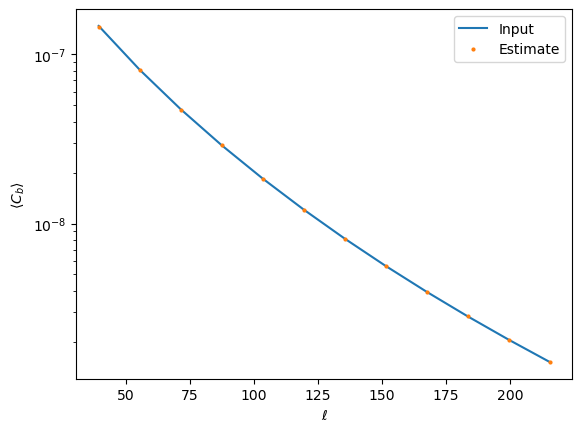

In [13]:
plt.plot(binned_ells,convolved_theory_cl,label='Input')
plt.plot(binned_ells,avg_Cb_decoupled   ,label='Estimate',ls='',marker='o',markersize=2)
plt.yscale('log')
plt.legend()
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\langle C_b \rangle$')
plt.show()

Text(0, 0.5, 'Fractional difference')

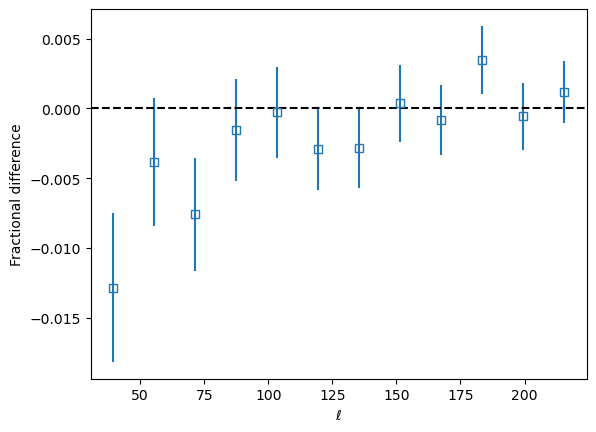

In [14]:
plt.errorbar(binned_ells,avg_Cb_decoupled/convolved_theory_cl-1,\
             yerr=err_Cb_decoupled/convolved_theory_cl,fmt='s',mfc='None')
plt.axhline(0, ls='--', color='k')
plt.xlabel(r'$\ell$')
plt.ylabel(r'Fractional difference')

# The End